In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# import bayesian estimation package
import ndim_homogeneous_distinguishability as hd
import fbm_analysis as fa
from fbm import FBM

## Get trajectory output for FBM trajectories in the same format as original homogeneous diffusion code

In [2]:
n_dim = 1
hurst = 0.5
dt = 1
n_steps = 50
loc_std = 0.3
d_const = 0.1

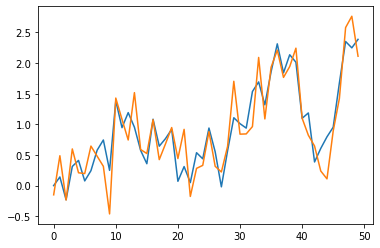

In [3]:
df = fa.simulate_fbm_df(d_const, n_dim, n_steps, dt, loc_std, hurst)
df.head()
d_msd =fa.get_fBm_diffusivity(df, dt)
d_bay = hd.estimate_diffusion(n_dim, dt, df['dr_obs'])[0].mean()

fa.plot_trajectory(df)

In [4]:
df.head()

,dr,dr_obs,dx,dx_obs,t_step,x,x_obs
0,0.140835,0.638233,[0.14083511165899368],[0.6382328781529634],0.0,[0.0],[-0.15092040392190775]
1,0.372168,0.722744,[-0.37216786817958025],[-0.7227440464901771],1.0,[0.14083511165899368],[0.4873124742310556]
2,0.543630,0.833631,[0.5436295236612192],[0.8336314061957768],2.0,[-0.23133275652058657],[-0.23543157225912142]
3,0.098760,0.389178,[0.09876048709317409],[-0.3891776775312451],3.0,[0.3122967671406326],[0.5981998339366554]
4,0.334613,0.012470,[-0.3346130789690209],[-0.012469753855479604],4.0,[0.4110572542338067],[0.20902215640541033]


## Estimating the underlying diffusion constant using bayesian inference

Imagining we don't know the real answer, can we use the set of step sizes to predict what the underlying diffusion constant was? Let's generate a posterior distribution for this set of (noisy) step sizes by passing them into our estimation method. Because we are predictin the variance of a nromal distribution with known mean, a inverse gamma function (parameterized by 'alpha' and 'beta' as a conjugate prior (https://en.wikipedia.org/wiki/Normal_distribution#With_known_mean).

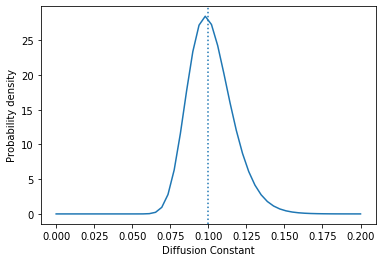

In [5]:
posterior, alpha, beta = hd.estimate_diffusion(n_dim = n_dim, dt = 1, dr = df['dr'])
xx = np.linspace(0, 0.2, 50)
plt.plot(xx, posterior.pdf(xx))
plt.axvline(x=d_const, linestyle=':')
plt.xlabel('Diffusion Constant')
plt.ylabel('Probability density');

Median beta value: 2.0762596825341797


Text(0, 0.5, 'Probability density')

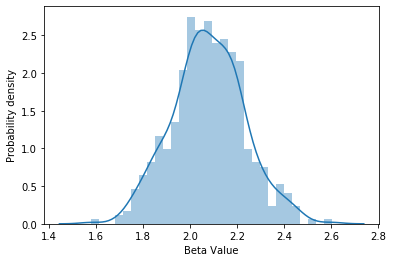

In [6]:
alpha_median, beta_median, alphas, betas = hd.get_posterior_set(n_dim=2, d_const=0.01, n_steps=200, dt=1, n_reps=500, loc_std=0.02, hurst=None)
print('Median beta value: '+str(beta_median))
sb.distplot(betas, bins=30);
plt.xlabel('Beta Value')
plt.ylabel('Probability density')

Now let's say I want to compare the posterior distributions I get for two trajectories with identical parameterizations but different diffusion constants (i.e. same number of spatial dimensions, same length, tmeporal resolution and localization error). I can generate and view a single posterior for these two trajectoires with diffusion constants D1 and D2=mult*D1 using a comparison method.

## Comparing posteriors for trajectories with differing underlying diffusion constants

KL div: 0.937964039134954
Inverse: 1.0661389544552895


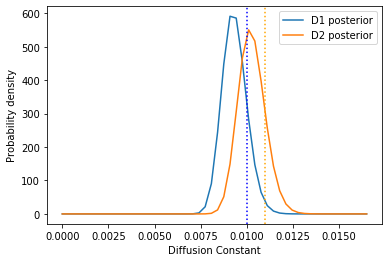

In [7]:
hd.compare2(n_dim=3, d_const1=0.01, mult=1.1, n_steps=200, dt=1, n_reps=10, loc_std = 0, hurst = 0.5)

This method also printed out for us the KL divergence between these two distributions, and its inverse, calculated using the 'invgamma_kldiv' function, based on this reference: https://arxiv.org/pdf/1605.01019.pdf. The inverse of the KL divergence is useful for thinking about psoterior distributions, because it is approximately the number of times you could draw from one distribution in place of the other before there is a significant amount of information loss. This offers us a single measurement of our ability to distinguish whether there is a difference between the diffusion constants underlying these two input trajectories.

## Now let's repeat this for many pairs of diffusion constants, and trajectories of many lengths, to create an experimental "lookup table"

Given two trajectories, our ability to distinguish whether their underlying diffusion constants differ willbe limited by how similar or different those two diffusion constants are (the 'mult' parameter in the 'compare2' function above). It will also be limited by the accuracy of the diffusion constant estimates themselves; given shorter trajectory length, we will have less information and therefor less accurate diffsuion estimates than if we had longer trajectories. To quantitatively explore the combination of these effects, we create a heatmap of pairwise posterior KL divergences, conditional on both the trajectory length and the relative diffusivity values. Each pixel in the heatmap will be the median values from N reps of calculating the KL divergence of a pair of posteriors estimated for trajcetories with diffusion cosntants D1 and D2, with trajcetory length T.

To see biologically relevant examples for diffusion constant orders of magnitude, check out BioNumbers:

http://book.bionumbers.org/what-are-the-time-scales-for-diffusion-in-cells/

In [8]:
# set diffusion constant multipliers to sweep through (D2 = mult*D1)
d_const1 = 0.01
Mmin = 1.0
Mmax = 10.
numM = 30
mult_list = np.linspace(Mmin, Mmax, numM)

# set trajectory lengths, timestep, and number of rep's on each D
n_steps = [5, 25, 50, 100, 200, 500, 1000]
dt = 1
n_reps = 10**3
hurst = 0.5

# set plotting parameters
x_lab = 'Trajectory Length T'
y_lab = r'$D_2/D_1$'
t1 = 'KL Divergence'
t2 = '1/(KL Divergence)'

In [9]:
# get df of pairwise KL divergence for each pair (D, mult*D)
KLdf_lin = hd.fill_heatmap_gen(n_dim=2, d_const=d_const1, mult_list=mult_list, n_steps=n_steps, dt=dt, n_reps=n_reps, hurst=hurst)
KLdf_lin.to_pickle('saved_data/KL_divergence/KL_lin_hurst'+str(hurst)+'.pickle')

In [0]:
# and plot that df as a heatmap of KL divergence values, and the log of the KL divergence values
KLdf_lin = pd.read_pickle('saved_data/KL_divergence/KL_lin_hurst'+str(hurst)+'.pickle')
max1 = 1000
max2 = 1
hd.plot_df_results(df1=KLdf_lin, df2=1/KLdf_lin, n_round=2, n_ticks=12, size=8, title1=t1, title2=t2, x_lab=x_lab, y_lab=y_lab, title='KL_lin_cut1000.pdf', vmax1 = max1, vmax2 = max2)

## Localization error

### Distribution of percent errors in the posterior, for a given trajectory length and localization error

If we include localization error, how does it impact the error in our diffusion constant estimates, depending on number of spatial dimensions? To look into this, we select one set of simulation parameters and rerun the trajectory simulation and posterior estimation N times, and collect a histogram of the percent error of the predicted diffusion constant relative to the true value. We repeat this in 1, 2, and 3 dimensions with all other trajectory parameters unchanged; then we can compare the resulting histograms across dimensions and decide whether we see an effect.

In [0]:
d_const = 0.1
n_steps = 10**3
dt = 1
n_reps = 10**4
n_dim = [1, 2, 3]
hurst = 0.5

In [0]:
std_list = [0, 0.00025, 0.0005, 0.00075, 0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.075, 0.1]
p_error = get_dim_error(n_dim = n_dim, d_const=d_cont, n_steps=n_steps, dt=de, n_reps=n_reps, show_plot=True, loc_std=std_list[2], hurst=hurst)
hd.show_error_hist(n_dim, p_error)

This was for a fixed amount of localization error. The dimensional effects on estimation error may be dependent on the amount of localization error. A separate analysis of this was completed in the Jupyter notebook 'test_overestimation.ipynb').

### Average percent error in posterior predictions, for many different trajetory lengths and levels of localization error

In each of the above we used a set trajectory length and standard deviation of localization error. Both of these contribute to the error in our posterior estimation. Let's look at how sensitive our error is to these pairs of parameters by looking at the average percent error over 10,000 repete trials for many different pairs of (trajectory length, error)

In [0]:
n_steps_list=[10, 15, 20, 25, 35, 50, 100, 150, 200]
loc_std=[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13]
df1m, df2m, df3m = hd.error_sensitivity(d_const=0.1, n_steps_list=n_steps_list, dt=1, n_reps=10**4, loc_std=loc_std, mag=True, hurst = hurst)
df1m.to_pickle('saved_data/posterior_error/DE-2/DE-2_d1_mag_hurst_'+str(hurst)+'.pickle')
df2m.to_pickle('saved_data/posterior_error/DE-2/DE-2_d2_mag_hurst_'+str(hurst)+'.pickle')
df3m.to_pickle('saved_data/posterior_error/DE-2/DE-2_d3_mag_hurst_'+str(hurst)+'.pickle')

In [0]:
df2m = pd.read_pickle('saved_data/posterior_error/DE-2/DE-2_d2_mag_hurst_'+str(hurst)+'.pickle')
sb.heatmap(df1m, cmap='viridis', cbar_kws={'label': 'Percent Estiamtion Error'})
plt.xlabel(r'Localization Error ($\mu$m)')
plt.ylabel('Trajectory length')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('post_error_DE-2mag_hurst'+str(hurst)+'.pdf', format='pdf')

In [0]:
df1m = pd.read_pickle('saved_data/posterior_error/DE-1/DE-1_d2_mag_hurst_'+str(hurst)+'.pickle')
sb.heatmap(df1m, cmap='viridis', cbar_kws={'label': 'Percent Estiamtion Error'})
plt.xlabel(r'Localization Error ($\mu$m)')
plt.ylabel('Trajectory length')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('post_error_DE-1mag._hurst'+str(hurst)+'.pdf', format='pdf')

## Repeat analysis with hurst = 0.7/2 to match biological scaling

In [0]:
# set diffusion constant multipliers to sweep through (D2 = mult*D1)
d_const1 = 0.01
Mmin = 1.0
Mmax = 10.
numM = 30
mult_list = np.linspace(Mmin, Mmax, numM)

# set trajectory lengths, timestep, and number of rep's on each D
n_steps = [5, 25, 50, 100, 200, 500, 1000]
dt = 1
n_reps = 10**3
hurst = 0.7/2

# set plotting parameters
x_lab = 'Trajectory Length T'
y_lab = r'$D_2/D_1$'
t1 = 'KL Divergence'
t2 = '1/(KL Divergence)'

In [0]:
# get df of pairwise KL divergence for each pair (D, mult*D)
KLdf_lin = hd.fill_heatmap_gen(n_dim=2, d_const=d_const1, mult_list=mult_list, n_steps=n_steps, dt=dt, n_reps=n_reps, hurst=hurst)
KLdf_lin.to_pickle('saved_data/KL_divergence/KL_lin_hurst'+str(hurst)+'.pickle')

In [0]:
round=2, n_ticks=12, size=8, title1=t1, title2=t2, x_lab=x_lab, y_lab=y_lab, title='KL_lin_cut1000_hurst'+str(hurst)+'.pdf', vmax1 = max1, vmax2 = max2)

In [0]:
d_const = 0.1
n_steps = 10**3
dt = 1
n_reps = 10**4
n_dim = [1, 2, 3]
hurst = 0.7/2

In [0]:
n_steps_list=[10, 15, 20, 25, 35, 50, 100, 150, 200]
loc_std=[0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 0.11, 0.12, 0.13]
df1m, df2m, df3m = hd.error_sensitivity(d_const=0.1, n_steps_list=n_steps_list, dt=1, n_reps=10**4, loc_std=loc_std, mag=True, hurst = hurst)
df1m.to_pickle('saved_data/posterior_error/DE-2/DE-2_d1_mag_hurst_'+str(hurst)+'.pickle')
df2m.to_pickle('saved_data/posterior_error/DE-2/DE-2_d2_mag_hurst_'+str(hurst)+'.pickle')
df3m.to_pickle('saved_data/posterior_error/DE-2/DE-2_d3_mag_hurst_'+str(hurst)+'.pickle')

In [0]:
df2m = pd.read_pickle('saved_data/posterior_error/DE-2/DE-2_d2_mag_hurst_'+str(hurst)+'.pickle')
sb.heatmap(df1m, cmap='viridis', cbar_kws={'label': 'Percent Estiamtion Error'})
plt.xlabel(r'Localization Error ($\mu$m)')
plt.ylabel('Trajectory length')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('post_error_DE-2mag_hurst'+str(hurst)+'.pdf', format='pdf')

In [0]:
df1m = pd.read_pickle('saved_data/posterior_error/DE-1/DE-1_d2_mag_hurst_'+str(hurst)+'.pickle')
sb.heatmap(df1m, cmap='viridis', cbar_kws={'label': 'Percent Estiamtion Error'})
plt.xlabel(r'Localization Error ($\mu$m)')
plt.ylabel('Trajectory length')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('post_error_DE-1mag._hurst'+str(hurst)+'.pdf', format='pdf')